# Ad Campaign Group Project

## 👥 Team Members
- Kenny Cen, Shaad Patankar

## Step 0: Setup
- Import Libraries (pandas, numpy, random, datetime, matplotlib, seaborn)

In [3]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import json
from faker import Faker
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data
- 1,000 users, 60% female, 2 to 8 campaigns per user

In [5]:
# initialize the Faker generator
fake = Faker()
Faker.seed(0)  # Seed for reproducible fake data
random.seed(0)  # Seed for reproducible random numbers

# Define total users and female ratio
NUM_USERS = 1000
FEMALE_RATIO = 0.6
NUM_FEMALES = int(NUM_USERS * FEMALE_RATIO)  # Calculate how many should be female (60%)

# Function to generate a fake user based on gender
def generate_user(gender):
    if gender == 'F':
        name = fake.name_female()  # Generate a female name
    else: name = fake.name_male()  # Generate a male name

    return {
        "name": name,
        "username": fake.user_name(),  # Generate a random username
        "gender": gender,
        "age": random.randint(18, 60), # Random age between 18 and 60
        "email": fake.email(),         # Random email
        "address": fake.address().replace("\n", ", ") # Random address (cleaned up)
    }

users = []  # List to hold all generated users
female_count = 0   # Counter to track how many female users have been added
for _ in range(NUM_USERS):
    if female_count < NUM_FEMALES:
        gender = 'F'  # Assign female until the target is reached 60%
        female_count += 1
    else:
        gender = 'M'  # Remaining users will be male

    user = generate_user(gender)  # Create user
    users.append(user)  # Add to the users list

In [6]:
# Function to generate a fake ad campaign for a user
def generate_campaign(user):
    start_date = fake.date_between(start_date='-3y', end_date='-1y') # Random start date between 1-3 years ago
    duration = random.randint(7, 180)  # Campaign last between 1 week to 6 months
    end_date = start_date + timedelta(days=duration)  # Calculate end date

    age_start = random.choice(range(18, 50, 5))
    age_end = random.choice(range(25, 65, 5))
    age_group = f"{age_start}-{age_end}"  # Combine to form string like "25-50"

    gender_target = user["gender"]  # Target gender same as user gender
    currency = "USD"  # All budgets in USD

    impressions = random.randint(1000, 100000)  # Total ad views
    clicks = random.randint(1, impressions)  # Clicks can't exceed impressions
    spent = round(random.uniform(100, 50000), 2)  # Random amount spent
    budget = round(spent * random.uniform(1.1, 2.0), 2)  # Budget is 10-100% more than spent

    return {
        "name": f"CPC_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}_{age_group}_{gender_target}_{currency}",
        "budget": budget,
        "spent": spent,
        "impressions": impressions,
        "clicks": clicks
    }

# Generate campaigns for each user
user_campaign_data = []

for user in users:
    num_campaigns = random.randint(2, 8)  # Each user has between 2 and 8 campaigns
    campaigns = []  # Temporary list to store this user's campaigns

    for _ in range(num_campaigns):  # Standard loop to generate campaigns
        campaign = generate_campaign(user)
        campaigns.append(campaign)

    user_campaign_data.append({     # Combine user info with their campaigns and store it
        "user": user,
        "campaigns": campaigns
    })

# Step 2: Clean and denormalize Data

In [7]:
# Flatten into desired structure for slide
flattened_for_df = []

for entry in user_campaign_data:
    user = entry["user"]
    user_str = json.dumps(user)  # convert to string (JSON)

    for campaign in entry["campaigns"]:
        flattened_for_df.append({
            "cmp_bgt": campaign["budget"],
            "cmp_clicks": campaign["clicks"],
            "cmp_impr": campaign["impressions"],
            "cmp_name": campaign["name"],
            "cmp_spent": campaign["spent"],
            "user": user_str
        })

df = pd.DataFrame(flattened_for_df)

df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,29384.95,19748,33935,CPC_20220708_20220901_48-40_F_USD,15680.38,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
1,4503.91,31453,94386,CPC_20230524_20230804_33-50_F_USD,2320.69,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
2,4513.00,57436,65920,CPC_20230326_20230420_18-60_F_USD,2468.68,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
3,4952.42,2806,16482,CPC_20240316_20240727_33-60_F_USD,4165.70,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
4,5861.94,40158,58755,CPC_20221227_20230211_33-40_F_USD,3949.45,"{""name"": ""Kelly Brown"", ""username"": ""davismary..."


# Step 3: Manipulate the Data

### Unpack Campaign Name

In [8]:
def unpack_cmp_name(cmp_name):
    parts = cmp_name.split("_")
    return pd.Series({
        "Type": parts[0],
        "Start": datetime.strptime(parts[1], "%Y%m%d").strftime("%Y-%m-%d"),
        "End": datetime.strptime(parts[2], "%Y%m%d").strftime("%Y-%m-%d"),
        "Age": parts[3],
        "Gender": parts[4],
        "Currency": parts[5]
    })

# Apply to DataFrame and create new columns
unpacked_df = df["cmp_name"].apply(unpack_cmp_name)

df = df.join(unpacked_df)

# Display result like the table in the slide
unpacked_df.head()

,Type,Start,End,Age,Gender,Currency
0,CPC,2022-07-08,2022-09-01,48-40,F,USD
1,CPC,2023-05-24,2023-08-04,33-50,F,USD
2,CPC,2023-03-26,2023-04-20,18-60,F,USD
3,CPC,2024-03-16,2024-07-27,33-60,F,USD
4,CPC,2022-12-27,2023-02-11,33-40,F,USD


### Unpack User Data

In [9]:
# Apply unpacking using .apply and return Series
user_info = df["user"].apply(lambda u: pd.Series(json.loads(u)))

# Rename columns to match the slide example
user_info = user_info[["username", "email", "name", "gender", "age", "address"]]

# Join with the original DataFrame (optional)
df = df.join(user_info)

# Display the user data only (like the slide)
user_info.head()

,username,email,name,gender,age,address
0,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
1,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
2,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
3,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
4,davismary,salazarmaria@example.com,Kelly Brown,F,44,"139 John Divide Suite 115, Rodriguezside, LA 9..."


### Calculate New Columns

In [10]:
df["CTR"] = df["cmp_clicks"] / df["cmp_impr"]
df["CPC"] = df["cmp_spent"] / df["cmp_clicks"]
df["CPI"] = df["cmp_spent"] / df["cmp_impr"]

### More New Columns

In [46]:
# Convert 'Start' and 'End' to datetime
df["Start"] = pd.to_datetime(df["Start"], format="%Y-%m-%d")
df["End"] = pd.to_datetime(df["End"], format="%Y-%m-%d")

# Setting age range labels
age_bins = [18, 25, 35, 45, 55, 65]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55+']

# Add new columns
df["start_day"] = df["Start"].dt.day_name()

# Create the new 'age_group' column using np.digitize and indexing
filtered_df = df[(df['age'] >= 18) & (df['age'] <= 65)]
df['age_group'] = np.array(age_labels)[np.digitize(filtered_df['age'], bins=age_bins, right=False) - 1]
df['age_group'] = pd.Categorical(df['age_group'], categories=age_labels, ordered=True)

df["campaign_duration_days"] = (df["End"] - df["Start"]).dt.days

# step 4: Save Dataframe to JSON format

In [12]:
df.to_json("cleaned_campaign_data.json", orient="records", indent=2)

# Step 5: Visualize, Explore. Aggregate.
- Where have we spent 75% of the budget?
- Break down by day of the week
- Analyze by target age group
- Visualize impressions, clicks, budget, and spent

In [13]:
sns.set(style='whitegrid')

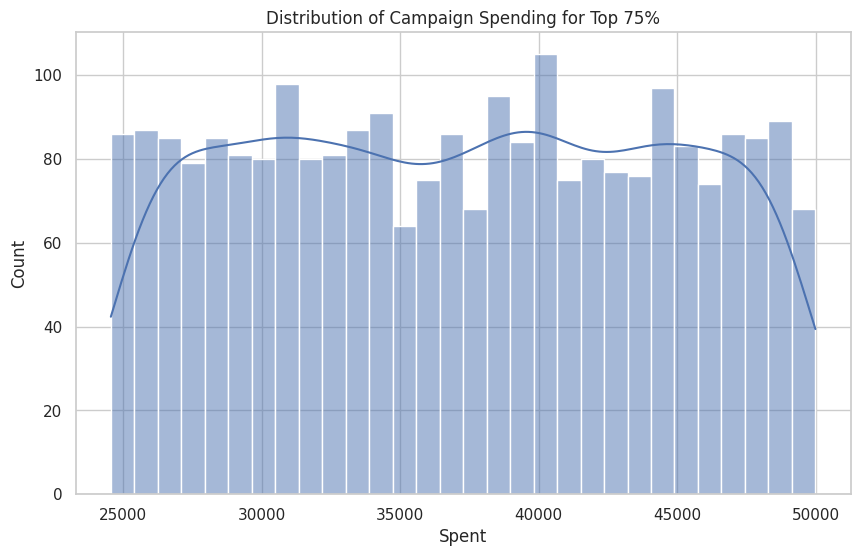

In [14]:
# Sort campaigns by spent, descending
df_sorted = df.sort_values("cmp_spent", ascending=False)

# Cumulative sum and % spent
df_sorted["cumulative_spent"] = df_sorted["cmp_spent"].cumsum()
total_spent = df["cmp_spent"].sum()
df_sorted["cumulative_spent_pct"] = df_sorted["cumulative_spent"] / total_spent

# Mark top 75%
top_75 = df_sorted[df_sorted["cumulative_spent_pct"] <= 0.75]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(top_75["cmp_spent"], bins=30, kde=True)
plt.title("Distribution of Campaign Spending for Top 75%")
plt.xlabel("Spent")
plt.ylabel("Count")
plt.show()

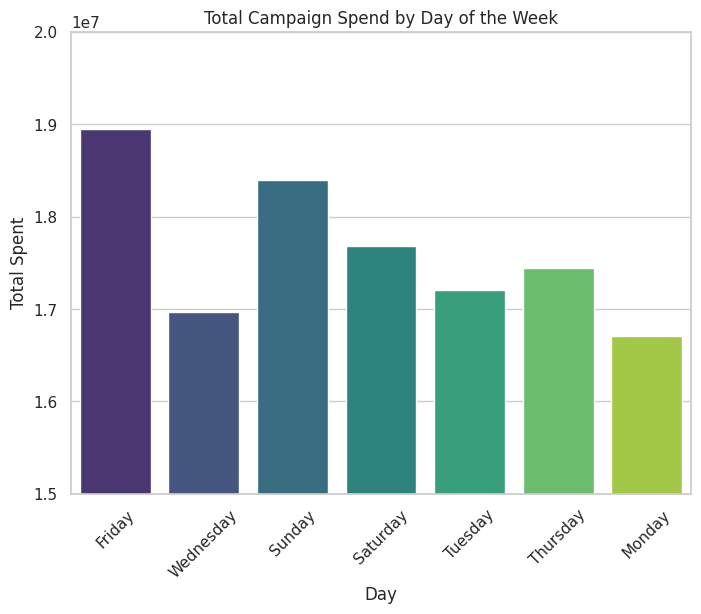

In [47]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="start_day", y="cmp_spent", estimator=sum, errorbar=None, hue="start_day", palette="viridis", dodge=False, legend=False) # ci is deprecated instead used 'errorbar'
plt.title("Total Campaign Spend by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Total Spent")
plt.xticks(rotation=45)
plt.ylim(15000000,20000000) #take a y range so we can better see differences between days
plt.show()

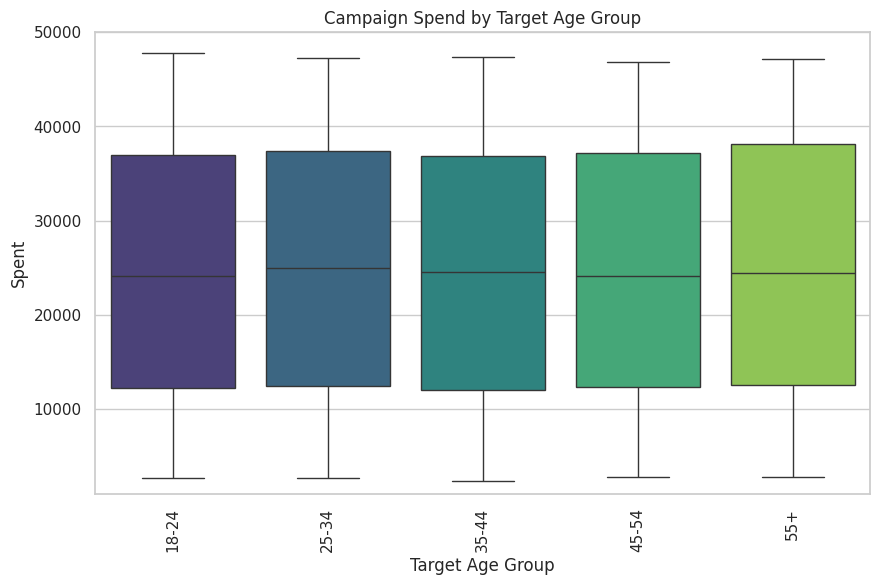

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="age_group", y="cmp_spent",hue = "age_group", palette="viridis", dodge=False, legend=False, whis=[5,95], showfliers=False)
plt.title("Campaign Spend by Target Age Group")
plt.xlabel("Target Age Group")
plt.ylabel("Spent")
plt.xticks(rotation=90)
plt.ylim(1000,50000)
plt.show()

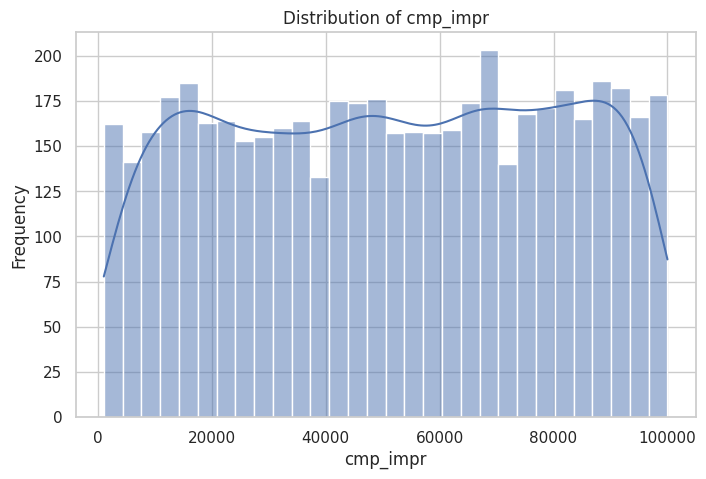

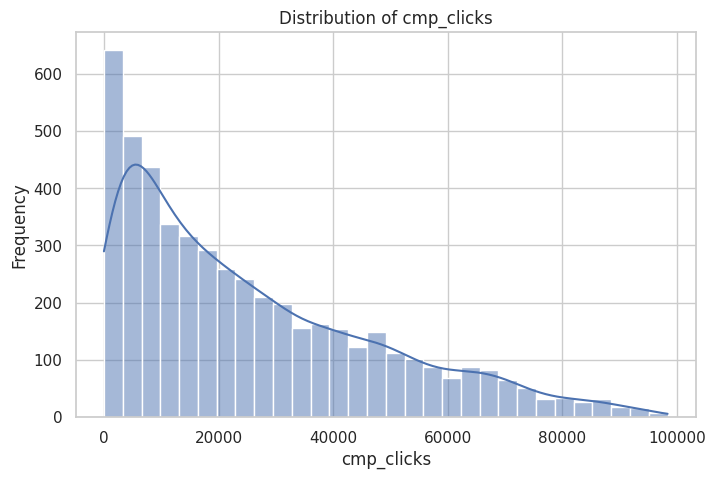

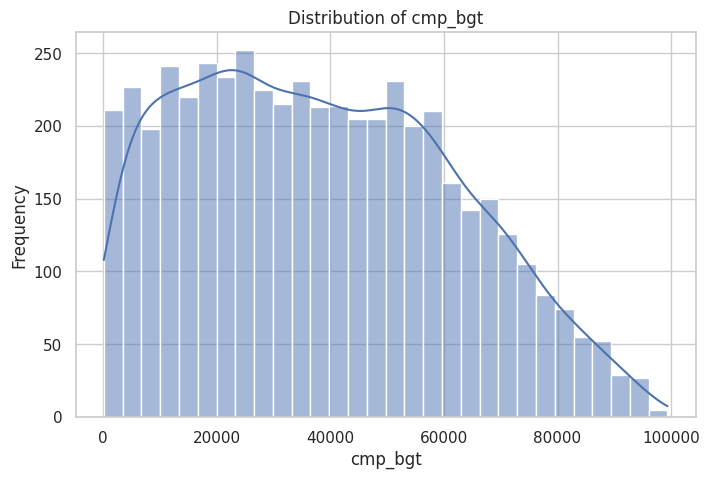

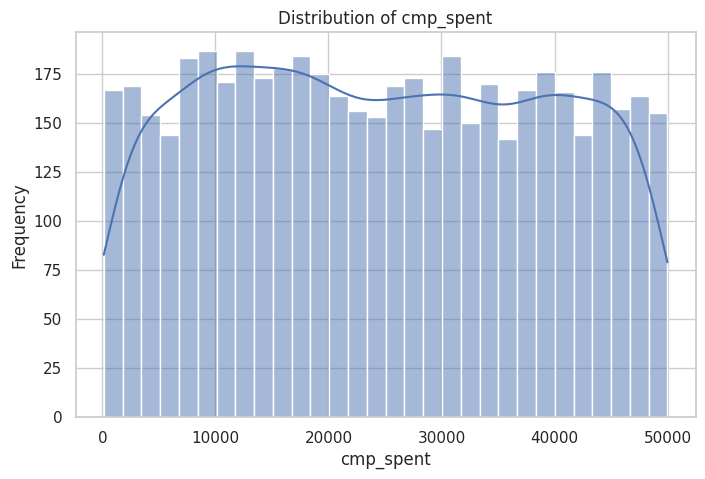

In [18]:
metrics = ["cmp_impr", "cmp_clicks", "cmp_bgt", "cmp_spent"]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[metric], bins=30, kde=True)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()